# Machine Learning - Global Terrorist Attacks

### Table of Contents

1. [Introduction](#Introduction)
2. [Data Exploration and Visualisation](#Data-Exploration-and-Visualisation)   
   2.1 [Reading in Data](#Reading-in-Data)   
   2.2 [Checking Null Values](#Checking-Null-Values)   
   2.3 [Columns and Values](#Columns-and-Values)   
      2.3.1 [Float Columns](#1.-Float-Columns)       
      2.3.2 [Integer Columns](#2.-Integer-Columns)      
      2.3.3 [Texts Columns](#3.-Texts-Columns)      
   2.4 [Groups - Known and Unknown](#Groups---Known-and-Unknown)   
   2.5 [Most Active Groups](#Most-Active-Groups)   
   2.6 [Most Volatile Years](#Most-Volatile-Years)   
   2.7 [Terrorist Attacks by Decades](#Terrorist-Attacks-by-Decades)   
   2.8 [Countries Most Affected by Terrorism](#Countries-Most-Affected-by-Terrorism)   
   2.9 [Terrorist Attacks by Regions](#Terrorist-Attacks-by-Regions)
3. [Modelling and Model Evaluation](#Modelling-and-Model-Evaluation)    
   3.1 [Feature Selection](#Feature-Selection)     
   3.2 [Dropping Summary Null Values](#Dropping-Summary-Null-Values)     
   3.3 [Separating Unknown and Known Groups](#Separating-Unknown-and-Known-Groups)     
   3.4 [Samples of Summary Column](#Samples-of-Summary-Column)     
   3.5 [Encoding Group Names](#Encoding-Group-Names)     
      3.5.1 [Binning Groups](#1.-Binning-Groups)     
      3.5.2 [Group Codes Dictionary](#2.-Group-Codes-Dictionary)     
      3.5.3 [Mapping Group Names](#3.-Mapping-Group-Names)     
      3.5.4 [Group Distributions](#4.-Group-Distributions)     
   3.6 [Features and Targets](#Features-and-Targets)     
   3.7 [Train Test Splits](#Train-Test-Splits)     
   3.8 [Vectorising Texts](#Vectorising-Texts)     
   3.9 [Naive Bayes](#Naive-Bayes)     
   3.10 [Logistic Regression](#Logistic-Regression)     
   3.11 [A Variation of KFold Cross Validation](#A-Variation-of-KFold-Cross-Validation)     
   3.12 [Predicting Unknown Groups](#Predicting-Unknown-Groups)     

## Introduction

I am doing this exercise as part of Fellowship AI Challenge. From the list of challenges, I selected Global Terrorist Attacks as my Challenge Problem.

[Global Terrorism Database (GTD)](http://www.start.umd.edu/gtd/about/) will be used for this. It is an open-source database including information on terrorist events around the world from 1970 through 2016.

For some portion of the attacks, the groups responsible have not been attributed. 

This exercise is an attempt to build a model using Machine Learning to predict which group may have been responsible for a terrorist incident.

## Data Exploration and Visualisation

Pandas and Numpy will be used for data analysis and data wrangling. For visualisation, we will use Matplotlib and Seaborn. Naive Bayes and Logistic Regression will be used to build Machine Learning models.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Reading in Data

The data downloaded from Global Terrorism Database was in Excel format, and it took a slightly longer time to load. So I had converted the file to CSV format encoded in utf-8.

The raw data is loaded into a pandas dataframe. df is short from dataframe.

In [2]:
%time df = pd.read_csv('globalterrorismdb_0617dist.csv', low_memory=False)

Wall time: 7.44 s


We take a look at the first few rows of the data.

In [3]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


The database contains over 170,000 cases of terrorist incidents, and we can verify that using shape of the loaded dataframe. Also, we see that there are 135 columns.

In [4]:
df.shape

(170350, 135)

The data is a mix of objects (strings, texts), floats and integers.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Columns: 135 entries, eventid to related
dtypes: float64(53), int64(24), object(58)
memory usage: 175.5+ MB


### Checking Null Values

There are some columns with many null values.

In [6]:
check_nulls = df.isnull().sum().sort_values(ascending=False)
check_nulls.head()

gsubname3           170337
weapsubtype4_txt    170279
weapsubtype4        170279
weaptype4           170276
weaptype4_txt       170276
dtype: int64

Lets convert the count of null values for the columns into percentages to analyse.

In [7]:
row_count = df.shape[0]
check_nulls_percentage = 100 * check_nulls / row_count
check_nulls_percentage.head()

gsubname3           99.992369
weapsubtype4_txt    99.958321
weapsubtype4        99.958321
weaptype4           99.956560
weaptype4_txt       99.956560
dtype: float64

To help with analysis, lets bin them into few groups. I had noticed that some columns didn't have any null values so I have put in the 0 bin. Otherwise they will be binned into 4 quartiles.

In [8]:
bins = (-1, 0, 25, 50, 75, 100)
labels = ['0 %','1-25 %','25-50 %','50-75 %','75-100 %']

check_nulls_percentage_grouped = pd.cut(check_nulls_percentage, bins, labels=labels)
check_nulls_percentage_grouped.head()

gsubname3           75-100 %
weapsubtype4_txt    75-100 %
weapsubtype4        75-100 %
weaptype4           75-100 %
weaptype4_txt       75-100 %
dtype: category
Categories (5, object): [0 % < 1-25 % < 25-50 % < 50-75 % < 75-100 %]

31 columns have no null values - this is out of 135 columns. Quite many columns - 70 of them, have more than 75% null values.

In [9]:
check_nulls_percentage_grouped_counts = check_nulls_percentage_grouped.value_counts()
check_nulls_percentage_grouped_counts.sort_index()

0 %         31
1-25 %      17
25-50 %     10
50-75 %      7
75-100 %    70
dtype: int64

Lets plot it.

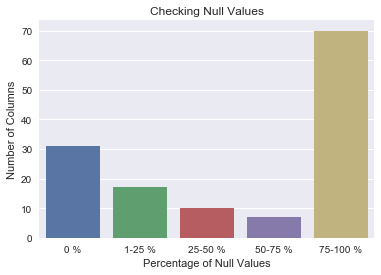

In [10]:
sns.barplot(check_nulls_percentage_grouped_counts.index, check_nulls_percentage_grouped_counts.values)
plt.title('Checking Null Values')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Number of Columns')

### Columns and Values

Lets trawl through the data to get a sense of different columns and their values. We will look at floats, integers and texts columns one by one.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Columns: 135 entries, eventid to related
dtypes: float64(53), int64(24), object(58)
memory usage: 175.5+ MB


### 1. Float Columns

Beginning with float columns.

When I was playing around with the data, I had attempted to build a model using 'weapsubtype1' among other columns. I had also gone through the column descriptions from the Codebook - it can be downloaded from GTD database. It contains detailed descriptions of columns and their values.

In [12]:
cols_float = df.select_dtypes(include=['float64']).columns
cols_float

Index(['latitude', 'longitude', 'specificity', 'alternative', 'attacktype2',
       'attacktype3', 'targsubtype1', 'natlty1', 'targtype2', 'targsubtype2',
       'natlty2', 'targtype3', 'targsubtype3', 'natlty3', 'guncertain1',
       'guncertain2', 'guncertain3', 'nperps', 'nperpcap', 'claimed',
       'claimmode', 'claim2', 'claimmode2', 'claim3', 'claimmode3',
       'compclaim', 'weapsubtype1', 'weaptype2', 'weapsubtype2', 'weaptype3',
       'weapsubtype3', 'weaptype4', 'weapsubtype4', 'nkill', 'nkillus',
       'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'propextent', 'propvalue',
       'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'ransom',
       'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus',
       'hostkidoutcome', 'nreleased'],
      dtype='object')

Takign a peek at the float columns.

In [13]:
df[cols_float].head(3)

,latitude,longitude,specificity,alternative,attacktype2,attacktype3,targsubtype1,natlty1,targtype2,targsubtype2,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased
0,18.456792,-69.951164,1.0,NaN,NaN,NaN,68.0,58.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,19.432608,-99.133207,1.0,NaN,NaN,NaN,45.0,21.0,NaN,NaN,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,NaN
2,15.478598,120.599741,4.0,NaN,NaN,NaN,54.0,217.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Integer Columns

Integer columns.

I had tried using 'iyear', 'country' and 'weaptype1' from these columns to build a model. The idea was - using the year in which the incident occured, along with the country, and weapon type and attack type used, can we predict which group may have been responsible.

For this, I had used KNN (K Nearest Neighbors). It did seem to give good predictions. But when I tried to encode the categorical columms like year, country, region etc, the number of columns exploded, and KNN likely suffered from Curse of Dimensionality. Running KNN became a drag. KNN worked fine till around 10k rows, but near around 100k rows, it struggled.

In [14]:
cols_int = df.select_dtypes(include=['int64']).columns
cols_int

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'region',
       'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple',
       'success', 'suicide', 'attacktype1', 'targtype1', 'individual',
       'weaptype1', 'property', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

First few rows from integer columns.

In [15]:
df[cols_int].head(3)

,eventid,iyear,imonth,iday,extended,country,region,vicinity,crit1,crit2,...,suicide,attacktype1,targtype1,individual,weaptype1,property,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,2,0,1,1,...,0,1,14,0,13,0,0,0,0,0
1,197000000002,1970,0,0,0,130,1,0,1,1,...,0,6,7,0,13,0,0,1,1,1
2,197001000001,1970,1,0,0,160,5,0,1,1,...,0,1,10,0,13,0,-9,-9,1,1


### 3. Texts Columns

Lastly, texts columns.

From these columns, I had tried using 'country_txt', 'region_txt', 'attacktype1_txt', 'weaptype1_txt' etc. Now is a good time to mention that 'gname' is what we are trying to predict. gname is short for terrorist group name.

In [16]:
cols_object = df.select_dtypes(include=['object']).columns
cols_object

Index(['approxdate', 'resolution', 'country_txt', 'region_txt', 'provstate',
       'city', 'location', 'summary', 'alternative_txt', 'attacktype1_txt',
       'attacktype2_txt', 'attacktype3_txt', 'targtype1_txt',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1_txt', 'targtype2_txt',
       'targsubtype2_txt', 'corp2', 'target2', 'natlty2_txt', 'targtype3_txt',
       'targsubtype3_txt', 'corp3', 'target3', 'natlty3_txt', 'gname',
       'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive',
       'claimmode_txt', 'claimmode2_txt', 'claimmode3_txt', 'weaptype1_txt',
       'weapsubtype1_txt', 'weaptype2_txt', 'weapsubtype2_txt',
       'weaptype3_txt', 'weapsubtype3_txt', 'weaptype4_txt',
       'weapsubtype4_txt', 'weapdetail', 'propextent_txt', 'propcomment',
       'divert', 'kidhijcountry', 'ransomnote', 'hostkidoutcome_txt',
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'related'],
      dtype='object')

First few rows from texts columns.

In [17]:
df[cols_object].head(3)

,approxdate,resolution,country_txt,region_txt,provstate,city,location,summary,alternative_txt,attacktype1_txt,...,divert,kidhijcountry,ransomnote,hostkidoutcome_txt,addnotes,scite1,scite2,scite3,dbsource,related
0,NaN,NaN,Dominican Republic,Central America & Caribbean,NaN,Santo Domingo,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
1,NaN,NaN,Mexico,North America,NaN,Mexico city,NaN,NaN,NaN,Hostage Taking (Kidnapping),...,NaN,Mexico,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
2,NaN,NaN,Philippines,Southeast Asia,Tarlac,Unknown,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN


### Groups - Known and Unknown

There are no null values in gname column.

In [18]:
df.gname.isnull().sum()

0

Group names are either Unknown or the names of the groups responsible for the incident are recorded. There are around 78,000 cases for which groups are uknown.

In [19]:
grp_counts = df.gname.value_counts()
grp_counts.head(10)

Unknown                                             78306
Taliban                                              6575
Shining Path (SL)                                    4551
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Al-Shabaab                                           2683
Irish Republican Army (IRA)                          2669
Revolutionary Armed Forces of Colombia (FARC)        2481
New People's Army (NPA)                              2414
Kurdistan Workers' Party (PKK)                       2152
Name: gname, dtype: int64

For around 92 thousand cases, groups are known.

In [20]:
grp_counts_known = grp_counts.loc[grp_counts.index != 'Unknown'].sum()
grp_counts_known

92044

As seen above as well, for 78,000 cases, groups are not known. So from a total of around 170,000 cases - for approx 100,000 cases, groups are known, and for the fraction of around 70,000 cases, groups are not known. Inference is that groups are known for majority of the cases.

In [21]:
grp_counts_unknown = grp_counts[0]
grp_counts_unknown

78306

Lets do a plot to visualise it.

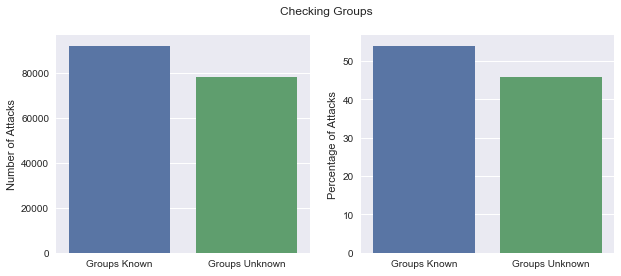

In [22]:
fig, (a0, a1) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Checking Groups')

sns.barplot(['Groups Known','Groups Unknown'],[grp_counts_known, grp_counts_unknown], ax=a0)
a0.set_ylabel('Number of Attacks')

sns.barplot(['Groups Known','Groups Unknown'],100 * np.array([grp_counts_known, grp_counts_unknown]) / row_count, ax=a1)
a1.set_ylabel('Percentage of Attacks')

### Most Active Groups

In total, there are 3453 groups in the database. We have to subtract 1 to account for the Unknown row.

In [23]:
grp_counts.shape

(3454,)

The number of incidents attributed to the top 15 most active groups.

In [24]:
top15 = grp_counts[1:16]
top15

Taliban                                             6575
Shining Path (SL)                                   4551
Islamic State of Iraq and the Levant (ISIL)         4287
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          2683
Irish Republican Army (IRA)                         2669
Revolutionary Armed Forces of Colombia (FARC)       2481
New People's Army (NPA)                             2414
Kurdistan Workers' Party (PKK)                      2152
Boko Haram                                          2077
Basque Fatherland and Freedom (ETA)                 2024
Communist Party of India - Maoist (CPI-Maoist)      1766
Liberation Tigers of Tamil Eelam (LTTE)             1606
National Liberation Army of Colombia (ELN)          1483
Maoists                                             1424
Name: gname, dtype: int64

Plotting to visualise.

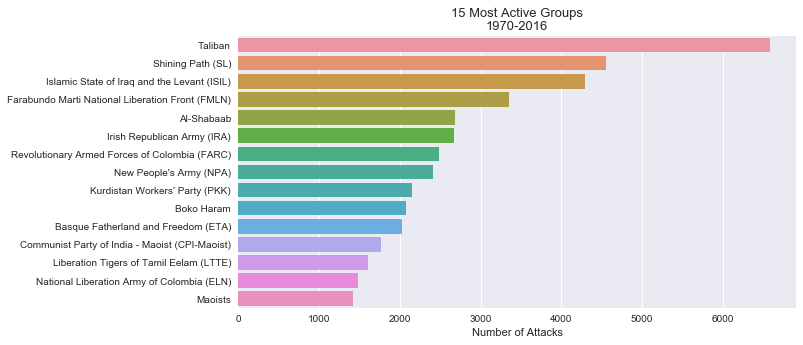

In [25]:
plt.subplots(figsize=(10, 5))
sns.barplot(top15.values, top15.index, orient='h')
plt.xlabel('Number of Attacks')
plt.title('15 Most Active Groups\n1970-2016', fontsize=13)

### Most Volatile Years

Top 15 years marred with terrorist incidents.

In [26]:
year_attacks = df.iyear.value_counts()
top15_years = year_attacks.sort_values(ascending=False).head(15)
top15_years

2014    16860
2015    14852
2016    13488
2013    11996
2012     8500
1992     5073
2011     5071
2010     4822
2008     4803
2009     4719
1991     4683
1989     4323
1990     3887
1988     3720
1984     3495
Name: iyear, dtype: int64

Doing a plot.

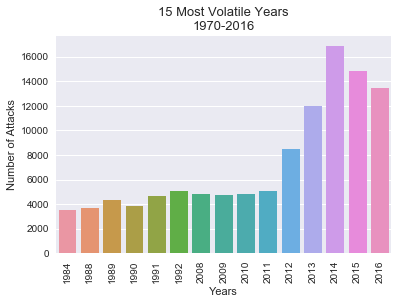

In [27]:
sns.barplot(top15_years.index, top15_years.values)
plt.xticks(rotation=90)
plt.ylabel('Number of Attacks')
plt.xlabel('Years')
plt.title('15 Most Volatile Years\n1970-2016', fontsize=13)

### Terrorist Attacks by Decades

Lets bin the years into decades.

In [28]:
bins = (1969, 1979, 1989, 1999, 2009, 2016)
labels = ['1970s', '1980s', '1990s', '2000s', '2010s']

year_decades = pd.cut(df.iyear, bins, labels=labels)
year_decades.head()

0    1970s
1    1970s
2    1970s
3    1970s
4    1970s
Name: iyear, dtype: category
Categories (5, object): [1970s < 1980s < 1990s < 2000s < 2010s]

Number of terrorist incidents by decades.

In [29]:
year_decades_attacks = year_decades.value_counts()
year_decades_attacks

2010s    75589
1980s    31159
1990s    28766
2000s    24997
1970s     9839
Name: iyear, dtype: int64

Plotting.

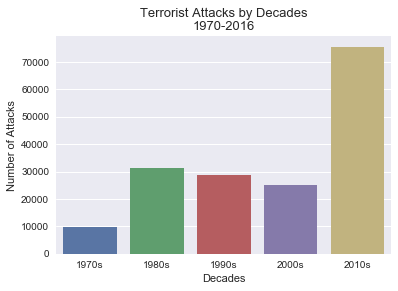

In [30]:
sns.barplot(year_decades_attacks.index, year_decades_attacks.values)
plt.xlabel('Decades')
plt.ylabel('Number of Attacks')
plt.title('Terrorist Attacks by Decades\n1970-2016', fontsize=13)

### Contries Most Affected by Terrorism

A list of 15 countries most affected.

In [31]:
country_attacks = df.country_txt.value_counts()
top15_countries = country_attacks.head(15)
top15_countries

Iraq              22130
Pakistan          13634
Afghanistan       11306
India             10978
Colombia           8163
Philippines        6212
Peru               6088
El Salvador        5320
United Kingdom     5098
Turkey             4106
Thailand           3668
Somalia            3482
Nigeria            3418
Spain              3245
Yemen              3109
Name: country_txt, dtype: int64

Visualising it.

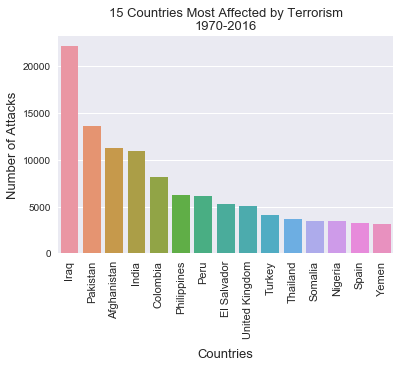

In [32]:
sns.barplot(top15_countries.index, top15_countries.values)
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Countries', labelpad=10, fontsize=13)
plt.ylabel('Number of Attacks', fontsize=13)
plt.title('15 Countries Most Affected by Terrorism\n1970-2016', fontsize=13)

### Terrorist Attacks by Regions

Number of terrorist incidents in each region.

In [33]:
region_attacks = df.region_txt.value_counts()
region_attacks

Middle East & North Africa     46511
South Asia                     41497
South America                  18762
Western Europe                 16307
Sub-Saharan Africa             15491
Southeast Asia                 11453
Central America & Caribbean    10340
Eastern Europe                  5031
North America                   3346
East Asia                        794
Central Asia                     554
Australasia & Oceania            264
Name: region_txt, dtype: int64

Plotting to visualise.

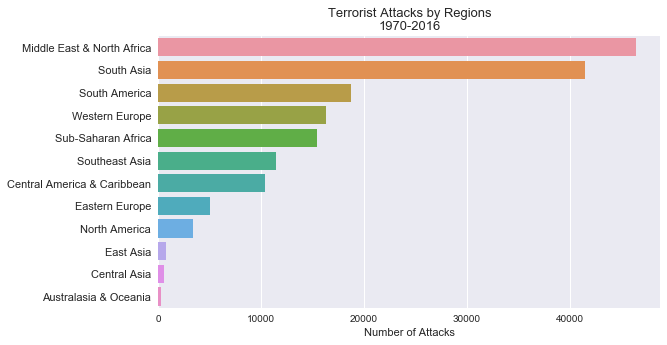

In [34]:
plt.subplots(figsize=(9, 5))
sns.barplot(region_attacks.values, region_attacks.index, orient='h')
plt.yticks(fontsize=11)
plt.xlabel('Number of Attacks', fontsize=11)
plt.title('Terrorist Attacks by Regions\n1970-2016', fontsize=13)

## Modelling and Model Evaluation

To start modelling, lets start by looking at the first few rows from the raw data.

In [35]:
df.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Verifying number of rows and columns again. We have 170,000 rows and 135 columns to work with.

In [36]:
df.shape

(170350, 135)

### Feature Selection

Our target column will be gname. This is the terrorist group name.

After trying with hand engineering different features, for example, I had tried with year, country, region, attack type used, weapon type used - and not getting satisfactory result (I tried with KNN and Logistic Regression), I was happily pleased to then have stumbled into machine learning from unstructured raw text data using Naive Bayes.

On further looking at summary column - this is the description of the terrorist incident or attack, I realised that this column is rich in information. It contains dates, years, months; and sometimes cities, towns and countries where the incident occurred. It also contained other information that would be difficult to capture by numbers alone.

So I decided to use summary column, rather than hand engineer columns one by one. It seemed to be the obvious choice.

So to proceed, I create a dataframe called summary_gname that has only summary and gname columns.

In [37]:
summary_gname = df.loc[:, ['summary','gname']]
summary_gname.head(3)

,summary,gname
0,NaN,MANO-D
1,NaN,23rd of September Communist League
2,NaN,Unknown


As we seen before, gname column has no null values. But summary has some null values. Around 60,000 of them. So from a total available of 170,000, if we let go of the 60,000 we will still have more than 100,000 to build our model.

We will end up dropping more rows later because of rows with Uknown gnames. But here we are now.

In [38]:
summary_gname.isnull().sum()

summary    66138
gname          0
dtype: int64

Lets take a look at the total number of groups - 3453. 

We will be needing this later on to compare - with how many groups we will actually end up building our model with.

In [39]:
summary_gname.gname.value_counts().shape

(3454,)

### Dropping Summary Null Values

After dropping summary column with null values, all NaN values are gone, and we are displayed with good texts data to work with in summary column.

In [40]:
summary_gname.dropna(inplace=True)
summary_gname.head(3)

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang


Checking shape of the data we have now. This is after dropping summary column with null values.

In [41]:
summary_gname.shape

(104212, 2)

### Separating Unknown and Known Groups

Around 55,000 cases have Unknown groups. These are ones we will be predicting for.

In [42]:
(summary_gname.gname == 'Unknown').sum()

55159

And around 50,000 cases - groups are known. These are the ones we will be working with to build a model.

In [43]:
(summary_gname.gname != 'Unknown').sum()

49053

Lets store the cases with Unknown groups separately. We will be using this to make final predictions.

In [44]:
unknown_grps = summary_gname.loc[summary_gname.gname == 'Unknown'].copy()
unknown_grps.head(3)

,summary,gname
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
40,1/31/1970: Unknown perpetrators bombed the Pol...,Unknown
43,2/2/1970: An incendiary device was discovered ...,Unknown


Rechecking the number of Unknown group cases - around 50,000.

In [45]:
unknown_grps.shape

(55159, 2)

Lets create a dataframe for the Known cases. We will be using this to build our model.

In [46]:
known_grps = summary_gname.loc[summary_gname.gname != 'Unknown'].copy()
known_grps.head(5)

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants


Rechecking Known group cases - slightly less than 50,000.

In [47]:
known_grps.shape

(49053, 2)

### Samples of Summary Column

Looking at few samples of summary column. As we can see, it is rich in information. It has dates, group names, target names, countries, cities, property damages, devices used, casualties etc.

In [48]:
known_grps.iloc[5,0]

"1/9/1970:  The Armed Commandos of Liberation claimed credit for setting a fire at the Baker's Store in Rio Piedras, Puerto Rico.  There were no casualties but the store was destroyed at a cost of $2,000,000."

In [49]:
known_grps.iloc[11,0]

'1/17/1970: Silas and Judith Bissell placed an explosive device in the vicinity of the Air Force R.O.T.C. at the University of Washington campus in Seattle, Washington, United States.  The device was discovered and subsequently disarmed.'

### Encoding Group Names

List of 10 most active groups.

In [50]:
grpCounts = known_grps.gname.value_counts()
grpCounts.head(10)

Taliban                                           6571
Islamic State of Iraq and the Levant (ISIL)       4287
Al-Shabaab                                        2683
Boko Haram                                        2077
Communist Party of India - Maoist (CPI-Maoist)    1766
New People's Army (NPA)                           1442
Maoists                                           1413
Revolutionary Armed Forces of Colombia (FARC)     1325
Tehrik-i-Taliban Pakistan (TTP)                   1252
Kurdistan Workers' Party (PKK)                    1127
Name: gname, dtype: int64

We are left with around 1500 groups to work with. Of the total of around 3500 groups that were there in the original database, some more than half had to be let go - this happened when we dropped summary column with null values. They don't have summary descriptions against the incidents attributed to them.

To build a model using the group names dropped, we have to hand engineer feature columns from the other 134 columns, which will be an exercise for another day.

In [51]:
grpCounts.shape

(1582,)

### 1. Binning Groups

Lets encode the group names. 

6 being the most active - they have caused more than 500 incidents. 1 is the least active group - they have been attributed to only one incident.

In [52]:
bins = (0, 1, 10, 50, 100, 500, 10000)
labels = [1, 2, 3, 4, 5, 6]

grpCuts = pd.cut(grpCounts, bins, labels=labels)
grpCuts.head()

Taliban                                           6
Islamic State of Iraq and the Levant (ISIL)       6
Al-Shabaab                                        6
Boko Haram                                        6
Communist Party of India - Maoist (CPI-Maoist)    6
Name: gname, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [53]:
grpCuts.tail()

Diraa al-Shahbaa Rebel Brigade                          1
Revolutionary Leninist Brigades                         1
Free Balochistan Army (FBA)                             1
National People's Party (Rashtriya Janata Dal - RJD)    1
Friendly Company                                        1
Name: gname, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

Group distribution.

16 groups were most active. 688 groups were involved reported in only one incident.

In [54]:
grpCuts.value_counts().sort_index()

1    688
2    601
3    189
4     41
5     47
6     16
Name: gname, dtype: int64

Dataframe below is a good depiction of the group distribution.

16 groups are grouped under group 6, and these groups have been attributed to more than 500 terrorist incidents each.

In [55]:
df_grpCodes = pd.DataFrame({'Group Code':np.arange(1,7),
            'Number of Groups':grpCuts.value_counts().sort_index(),
            'Number of Attacks (Range)':['1', '2-10','10-50','50-100','100-500','500-10000']})
df_grpCodes.set_index('Group Code', inplace=True)
df_grpCodes

,Number of Attacks (Range),Number of Groups
Group Code,,
1,1,688
2,2-10,601
3,10-50,189
4,50-100,41
5,100-500,47
6,500-10000,16


Rechecking total number of groups. Around 1500.

In [56]:
df_grpCodes['Number of Groups'].sum()

1582

### 2. Group Codes Dictionary

Building a dictionary to store the groups into their respective group codes. Groups 1 to 6.

In [57]:
grpDict = {}
for grpCode in range(1, 7):
    grpDict[grpCode] = grpCuts[grpCuts.values == grpCode].index.tolist()

Taking a look at a group. 

10 Group names in group 6. They have been attributed to more than 500 incidents each.

In [58]:
grpDict[6][:10]

['Taliban',
 'Islamic State of Iraq and the Levant (ISIL)',
 'Al-Shabaab',
 'Boko Haram',
 'Communist Party of India - Maoist (CPI-Maoist)',
 "New People's Army (NPA)",
 'Maoists',
 'Revolutionary Armed Forces of Colombia (FARC)',
 'Tehrik-i-Taliban Pakistan (TTP)',
 "Kurdistan Workers' Party (PKK)"]

10 group names in group 5. They have been attributed to 100-500 incidents each.

In [59]:
grpDict[5][:10]

['Abu Sayyaf Group (ASG)',
 'Fulani extremists',
 'Separatists',
 'Palestinian Extremists',
 'National Liberation Army of Colombia (ELN)',
 'Algerian Islamic Extremists',
 'Tripoli Province of the Islamic State',
 'Hamas (Islamic Resistance Movement)',
 'Sinai Province of the Islamic State',
 'Chechen Rebels']

### 3. Mapping Group Names

Defining a function to map group names with their group codes.

And mapping them.

In [60]:
def grpCodes(gname):
    for key, values in grpDict.items():
        if gname in values:
            return key

known_grps['gname_code'] = known_grps.gname.map(lambda x: grpCodes(x))
known_grps.head()

,summary,gname,gname_code
5,1/1/1970: Unknown African American assailants ...,Black Nationalists,4
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants,5
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants,5


### 4. Group Distributions

Number of incidents attributed to the groups encoded. Groups 1 to 6.

Group 6 caused an unproportionate number of attacks. And they consist of just 16 groups.

In [61]:
known_grps.gname_code.value_counts().sort_index()

1      688
2     2400
3     4371
4     2821
5    10480
6    28293
Name: gname_code, dtype: int64

Below dataframe depicts groups distributions very nicely.

Group 6 has groups that has been attributed to be responsible for more than 500 attacks. There are 16 groups in this group. In total, these 16 groups have been resposible for around 28,000 attacks.

In [62]:
df_grpCodes['Number of Attacks (Total)'] = known_grps.gname_code.value_counts().sort_index()
df_grpCodes

,Number of Attacks (Range),Number of Groups,Number of Attacks (Total)
Group Code,,,
1,1,688,688
2,2-10,601,2400
3,10-50,189,4371
4,50-100,41,2821
5,100-500,47,10480
6,500-10000,16,28293


### Features and Targets

X is the feature - summary, descriptions of the terrorist incident.

y is the target - terrorist groups responsible.

We are using X to predict y.

In [63]:
X = known_grps.summary
y = known_grps.gname_code

Checking shape of feature and target. We will be working with around 50,000 features and targets.

In [64]:
X.shape, y.shape

((49053,), (49053,))

Checking data type of X and y. Scikit Learn models expect numpy arrays. But because pandas is built on top of Numpy, pandas series is fine too.

In [65]:
type(X), type(y)

(pandas.core.series.Series, pandas.core.series.Series)

### Train Test Splits

Spliting into Training and Testing sets.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Checking shapes after splitting. By default, it's split at 75:25 ratio, 75 for training and 25 for testing.

In [67]:
splits = [X_train, X_test, y_train, y_test]
for _ in splits:
    print(_.shape)

(36789,)
(12264,)
(36789,)
(12264,)


### Vectorising Texts

Initialise CountVectorizer. This will be used to vectorise the summary texts, which can then be used to feed into machine learning models.

In [68]:
vect = CountVectorizer()

It learns the vocabulary from the training samples here.

In [69]:
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Converts the learned vocabulary into matrix. dtm is short for document term matrix.

In [70]:
X_train_dtm = vect.transform(X_train)
X_train_dtm

<36789x43840 sparse matrix of type '<class 'numpy.int64'>'
	with 1591355 stored elements in Compressed Sparse Row format>

Transforming the test set. 

Notice that the number of columns are same between X_train_dtm and X_test_dtm. 

A mistake would be to vectorise and split. Correct procedure is to split into train and test sets, vectorise using train set, and then transform the test set using the instance that was used to vectorise train set texts.

In [71]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<12264x43840 sparse matrix of type '<class 'numpy.int64'>'
	with 524004 stored elements in Compressed Sparse Row format>

### Naive Bayes

Intialising Naive Bayes.

In [72]:
nb = MultinomialNB()

We are passing X_train_dtm, and not X_train.

Note the time taken - just some 100 milliseconds. We will see that it is much faster than Logistic Regression.

In [73]:
%time nb.fit(X_train_dtm, y_train)

Wall time: 111 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Predicting using Naive Bayes. Note that we are passing X_test_dtm, and not X_test.

In [74]:
y_pred_nb = nb.predict(X_test_dtm)

Naive Bayes gives accuracy score of around 85%.

We will see that Logistic Regression gives better accuracy score, but it's slower.

In [75]:
metrics.accuracy_score(y_test, y_pred_nb)

0.85127201565557731

Confusion Matrix - we get a 6 by 6 matrix for 6 groups. The topmost left is for group 1 while bottom right corner is for group 6.

Naive Bayes did pretty well with predicting groups from group 6 but it struggled to find any predictions from group 1, perhaps because of less samples.

In [76]:
metrics.confusion_matrix(y_test, y_pred_nb)

array([[   0,   22,   58,   11,   68,   31],
       [   0,  137,  108,   23,  178,  129],
       [   0,   11,  603,   27,  236,  197],
       [   0,    4,   70,  375,  140,   88],
       [   0,    6,   41,   18, 2349,  217],
       [   0,    9,   66,    5,   61, 6976]])

Below we get f1 score along with precision and recall.

Notice how for group 6, it looks quite good, while for group 1 it is all 0. Overall f1 score is 83%.

In [77]:
print(metrics.classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       190
          2       0.72      0.24      0.36       575
          3       0.64      0.56      0.60      1074
          4       0.82      0.55      0.66       677
          5       0.77      0.89      0.83      2631
          6       0.91      0.98      0.95      7117

avg / total       0.83      0.85      0.83     12264



### Logistic Regression

Initialising an instance of Logistic Regression.

In [78]:
lr = LogisticRegression()

Fitting a model with Logistic Regression. 

Notice that it took around 25 seconds, while we saw that with Naive Bayes, it took just some 100 milliseconds.

In [79]:
%time lr.fit(X_train_dtm, y_train)

Wall time: 25.6 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predicting with Logistic Regression.

In [80]:
y_pred_lr = lr.predict(X_test_dtm)

We get accuracy score of 92%, much higher than Naive Bayes.

So looks like the trade off is between speed and accuracy.

In [81]:
metrics.accuracy_score(y_test, y_pred_lr)

0.9289791258969341

Confusion Matrix for Logistic Regression.

Notice here that it did predict some group 1s, unlike with Naive Bayes. It did well with group 6 anyways.

In [82]:
metrics.confusion_matrix(y_test, y_pred_lr)

array([[  21,   67,   47,    9,   29,   17],
       [  13,  373,   56,   30,   58,   45],
       [   4,   57,  849,   31,   65,   68],
       [   3,   10,   25,  584,   23,   32],
       [   1,   14,   36,   13, 2537,   30],
       [   2,   19,   25,    7,   35, 7029]])

F1 score along with precision and recall for Logistic Regression.

Here, interesting to note is precisiong and recall for group 1 is no longer 0 like with Naive Bayes.

In [83]:
print(metrics.classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          1       0.48      0.11      0.18       190
          2       0.69      0.65      0.67       575
          3       0.82      0.79      0.80      1074
          4       0.87      0.86      0.86       677
          5       0.92      0.96      0.94      2631
          6       0.97      0.99      0.98      7117

avg / total       0.92      0.93      0.92     12264



### A Variation of KFold Cross Validation

Now that we have tried once with both Naive Bayes and Logistic Regression, lets try few runs of each and take their means so that the results we got above was not a one-time-lucky phenomenon.

To achieve that lets define a function as below.

The function will run for 3 iterations, and return accuracy scores and f1 scores for the 3 runs. We will use them to calculate means of the scores.

In [84]:
def mean_clf(X, y, clf):
    
    accuracyScores = []
    f1Scores = []
    
    for iter in range(3):    
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        vect = CountVectorizer()
        vect.fit(X_train)
        X_train_dtm = vect.transform(X_train)
        X_test_dtm = vect.transform(X_test)

        clf.fit(X_train_dtm, y_train)
        y_pred = clf.predict(X_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred, average='weighted')
        accuracyScores.append(accuracy)
        f1Scores.append(f1)
    
    return accuracyScores, f1Scores

Lets run first for Naive Bayes.

In [85]:
%%time
nb = MultinomialNB()
accuracy_nb, f1_nb = mean_clf(X, y, nb)
print(accuracy_nb)
print(f1_nb)

[0.84801043705153289, 0.85510437051532939, 0.85094585779517284]
[0.82942778157915287, 0.83717966149200063, 0.83233591263335238]
Wall time: 21.4 s


The results look consistent.

Trying with Logistic Regression.

In [86]:
%%time
lr = LogisticRegression()
accuracy_lr, f1_lr = mean_clf(X, y, lr)
print(accuracy_lr)
print(f1_lr)

[0.93109915198956295, 0.92865296803652964, 0.93085453359425963]
[0.92576701840515363, 0.92395086713249164, 0.92605988543565632]
Wall time: 1min 30s


The results look consistent for Logistic Regression too.

Lets build a dataframe to summarise.

In [87]:
pd.DataFrame({'Accuracy Score':[np.array(accuracy_nb).mean(), np.array(accuracy_lr).mean()],
             'F1 Score': [np.array(f1_nb).mean(), np.array(f1_lr).mean()]},
             index=['Naive Bayes','Logistic Regression'])

,Accuracy Score,F1 Score
Naive Bayes,0.851354,0.832981
Logistic Regression,0.930202,0.925259


### Predicting Unknown Groups

So we have worked with building 2 models - Naive Bayes and Logistic Regression, and evaluated them.

Now let's see what the predictions for the Unknown groups come out to be.

Before we predict, we should use the whole dataset to train again, else we end up throwing away useful data.

Lets use CountVectorizer to vectorise X - this has the whole dataset. Not just training set.

In [88]:
%%time
vect = CountVectorizer()
vect.fit(X)
X_dtm = vect.transform(X)
unknown_grps_dtm = vect.transform(unknown_grps.summary)

Wall time: 11.4 s


Predicting with Naive Bayes.

In [89]:
%%time
nb = MultinomialNB()
nb.fit(X_dtm, y)
unknown_grps_pred_nb = nb.predict(unknown_grps_dtm)
print(unknown_grps_pred_nb)

[4 4 4 ..., 6 5 5]
Wall time: 149 ms


Predicting with Logistic Regression.

In [90]:
%%time
lr = LogisticRegression()
lr.fit(X_dtm, y)
unknown_grps_pred_lr = lr.predict(unknown_grps_dtm)
print(unknown_grps_pred_lr)

[4 5 4 ..., 6 5 2]
Wall time: 32.3 s


Distribution of predictions from Naive Bayes.

In [91]:
nb_pred = pd.Series(unknown_grps_pred_nb).value_counts().sort_index()
nb_pred

1        1
2      518
3     4464
4     1131
5    14585
6    34460
dtype: int64

Distribution of predictions from Logistic Regression.

In [92]:
lr_pred = pd.Series(unknown_grps_pred_lr).value_counts().sort_index()
lr_pred

1      727
2     3129
3     6587
4     2608
5    13979
6    28129
dtype: int64

Summarising predictions from both Naive Bayes and Logistic Regression.

In [93]:
df_pred = pd.DataFrame({'Naive Bayes': nb_pred,
             'Logistic Regression': lr_pred,
             'Group Code': np.arange(1, 7)}).set_index('Group Code')
df_pred = df_pred[['Naive Bayes','Logistic Regression']]
df_pred

,Naive Bayes,Logistic Regression
Group Code,,
1,1,727
2,518,3129
3,4464,6587
4,1131,2608
5,14585,13979
6,34460,28129
